In [2]:
from huggingface_hub import notebook_login

notebook_login()

In [3]:
%%capture
!sudo apt -qq install git-lfs
!git config --global credential.helper store

In [4]:
import numpy as np
import torch
import torch.nn.functional as F
from matplotlib import pyplot as plt
from PIL import Image

In [5]:
def show_images(x):
    """Given a batch of images x, make a grid and convert to PIL"""
    x = x * 0.5 + 0.5  # Map from (-1, 1) back to (0, 1)
    grid = torchvision.utils.make_grid(x)
    grid_im = grid.detach().cpu().permute(1, 2, 0).clip(0, 1) * 255
    grid_im = Image.fromarray(np.array(grid_im).astype(np.uint8))
    return grid_im

In [6]:
def make_grid(images, size=64):
    """Given a list of PIL images, stack them together into a line for easy viewing"""
    output_im = Image.new("RGB", (size * len(images), size))
    for i, im in enumerate(images):
        output_im.paste(im.resize((size, size)), (i * size, 0))
    return output_im

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [8]:
print(torch.backends.cudnn.enabled)

True


In [9]:
print(device)

cuda


In [10]:
torch.cuda.is_available()

True

In [11]:
print(torch.version.cuda)

11.8


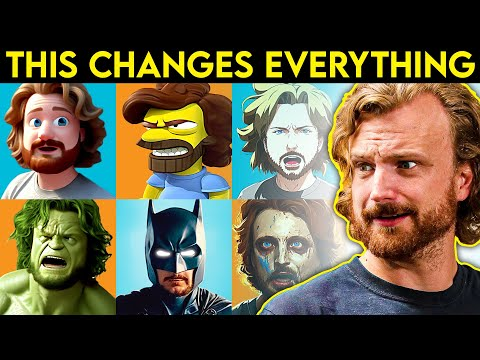

In [12]:
from IPython.display import YouTubeVideo

YouTubeVideo("W4Mcuh38wyM")

In [13]:
#pipeline
from diffusers import StableDiffusionPipeline

In [14]:
model_id = "sd-dreambooth-library/mr-potato-head"

In [15]:
print(model_id)

sd-dreambooth-library/mr-potato-head


In [16]:
#load pipeline
pipe = StableDiffusionPipeline.from_pretrained(model_id, torch_dtype=torch.float16).to(device)


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

An error occurred while trying to fetch C:\Users\hesal5042\.cache\huggingface\hub\models--sd-dreambooth-library--mr-potato-head\snapshots\34246b94acd8b96166e8d93eaded001c380a2d4e\vae: Error no file named diffusion_pytorch_model.safetensors found in directory C:\Users\hesal5042\.cache\huggingface\hub\models--sd-dreambooth-library--mr-potato-head\snapshots\34246b94acd8b96166e8d93eaded001c380a2d4e\vae.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.
An error occurred while trying to fetch C:\Users\hesal5042\.cache\huggingface\hub\models--sd-dreambooth-library--mr-potato-head\snapshots\34246b94acd8b96166e8d93eaded001c380a2d4e\unet: Error no file named diffusion_pytorch_model.safetensors found in directory C:\Users\hesal5042\.cache\huggingface\hub\models--sd-dreambooth-library--mr-potato-head\snapshots\34246b94acd8b96166e8d93eaded001c380a2d4e\unet.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.


c:\Users\hesal5042\AppData\Local\anaconda3\envs\diffusion\lib\site-packages\transformers\models\clip\modeling_clip.py:491: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:555.)
  attn_output = torch.nn.functional.scaled_dot_product_attention(


  0%|          | 0/18 [00:00<?, ?it/s]

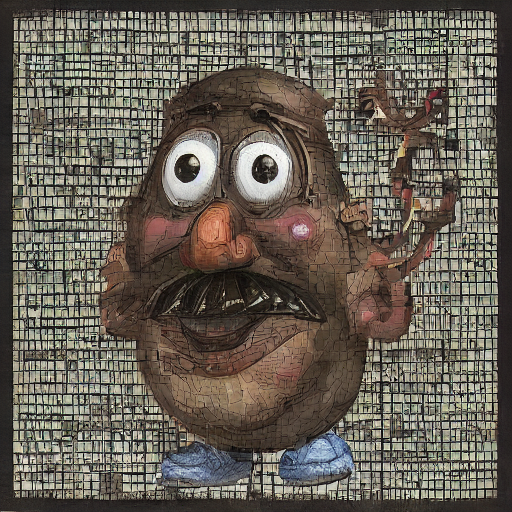

In [17]:
prompt = "an abstract oil painting of mr potato head by picasso"
image = pipe(prompt, num_inference_steps=18, guidance_scale=1).images[0]
image

In [18]:
#Build our own pipeline and generate images

#1. Pipeline
from diffusers import DDPMPipeline


In [19]:
#own dataset

Loading pipeline components...:   0%|          | 0/2 [00:00<?, ?it/s]

An error occurred while trying to fetch C:\Users\hesal5042\.cache\huggingface\hub\models--johnowhitaker--ddpm-butterflies-32px\snapshots\ff99059aed185f6158729b8e9f2286c4b9c177f3: Error no file named diffusion_pytorch_model.safetensors found in directory C:\Users\hesal5042\.cache\huggingface\hub\models--johnowhitaker--ddpm-butterflies-32px\snapshots\ff99059aed185f6158729b8e9f2286c4b9c177f3.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.


  0%|          | 0/1000 [00:00<?, ?it/s]

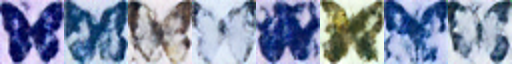

In [20]:

# Load the butterfly pipeline
butterfly_pipeline = DDPMPipeline.from_pretrained("johnowhitaker/ddpm-butterflies-32px").to(device)

# Create 8 images
images = butterfly_pipeline(batch_size=8).images

# View the result
make_grid(images)

In [21]:
import torchvision
from datasets import load_dataset
from torchvision import transforms

dataset = load_dataset("huggan/smithsonian_butterflies_subset", split="train")

# Or load images from a local folder
# dataset = load_dataset("imagefolder", data_dir="path/to/folder")

# We'll train on 32-pixel square images, but you can try larger sizes too
image_size = 32
# You can lower your batch size if you're running out of GPU memory
batch_size = 64

# Define data augmentations
preprocess = transforms.Compose(
    [
        transforms.Resize((image_size, image_size)),  # Resize
        transforms.RandomHorizontalFlip(),  # Randomly flip (data augmentation)
        transforms.ToTensor(),  # Convert to tensor (0, 1)
        transforms.Normalize([0.5], [0.5]),  # Map to (-1, 1)
    ]
)


def transform(examples):
    images = [preprocess(image.convert("RGB")) for image in examples["image"]]
    return {"images": images}


dataset.set_transform(transform)

# Create a dataloader from the dataset to serve up the transformed images in batches
train_dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

Repo card metadata block was not found. Setting CardData to empty.


X shape: torch.Size([8, 3, 32, 32])


C:\Users\hesal5042\AppData\Local\Temp\ipykernel_20168\1866057003.py:6: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  grid_im = Image.fromarray(np.array(grid_im).astype(np.uint8))


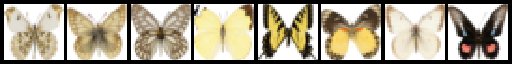

In [22]:
xb = next(iter(train_dataloader))["images"].to(device)[:8]
print("X shape:", xb.shape)
show_images(xb).resize((8 * 64, 64), resample=Image.NEAREST)

In [23]:
#2. Scheduler
from diffusers import DDPMScheduler

#noise_scheduler = DDPMScheduler(num_train_timesteps=1000)
#noise_scheduler = DDPMScheduler(num_train_timesteps=1000, beta_start=0.001, beta_end=0.004) #One with too little noise added
noise_scheduler = DDPMScheduler(num_train_timesteps=1000, beta_schedule='squaredcos_cap_v2') #The 'cosine' schedule, which may be better for small image sizes

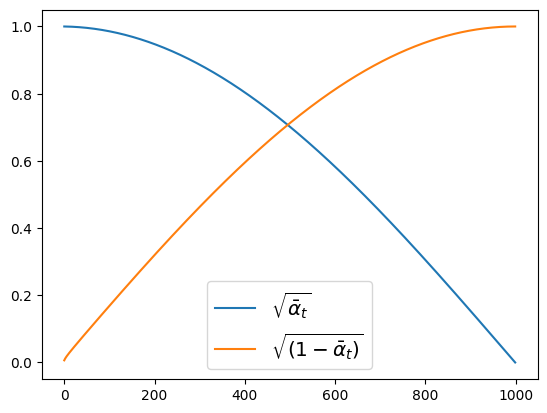

In [24]:
plt.plot(noise_scheduler.alphas_cumprod.cpu() ** 0.5, label=r"${\sqrt{\bar{\alpha}_t}}$")
plt.plot((1 - noise_scheduler.alphas_cumprod.cpu()) ** 0.5, label=r"$\sqrt{(1 - \bar{\alpha}_t)}$")
plt.legend(fontsize="x-large")

Noisy X shape torch.Size([8, 3, 32, 32])


C:\Users\hesal5042\AppData\Local\Temp\ipykernel_20168\1866057003.py:6: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  grid_im = Image.fromarray(np.array(grid_im).astype(np.uint8))


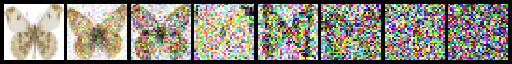

In [25]:
timesteps = torch.linspace(0, 999, 8).long().to(device)
noise = torch.randn_like(xb)
noisy_xb = noise_scheduler.add_noise(xb, noise, timesteps)
print("Noisy X shape", noisy_xb.shape)
show_images(noisy_xb).resize((8 * 64, 64), resample=Image.NEAREST)

In [26]:
#3. Model
from diffusers import UNet2DModel

# Create a model
model = UNet2DModel(
    sample_size=image_size,  # the target image resolution
    in_channels=3,  # the number of input channels, 3 for RGB images
    out_channels=3,  # the number of output channels
    layers_per_block=2,  # how many ResNet layers to use per UNet block
    block_out_channels=(64, 128, 128, 256),  # More channels -> more parameters
    down_block_types=(
        "DownBlock2D",  # a regular ResNet downsampling block
        "DownBlock2D",
        "AttnDownBlock2D",  # a ResNet downsampling block with spatial self-attention
        "AttnDownBlock2D",
    ),
    up_block_types=(
        "AttnUpBlock2D",
        "AttnUpBlock2D",  # a ResNet upsampling block with spatial self-attention
        "UpBlock2D",
        "UpBlock2D",  # a regular ResNet upsampling block
    ),
)
model.to(device)

UNet2DModel(
  (conv_in): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (time_proj): Timesteps()
  (time_embedding): TimestepEmbedding(
    (linear_1): Linear(in_features=64, out_features=256, bias=True)
    (act): SiLU()
    (linear_2): Linear(in_features=256, out_features=256, bias=True)
  )
  (down_blocks): ModuleList(
    (0): DownBlock2D(
      (resnets): ModuleList(
        (0-1): 2 x ResnetBlock2D(
          (norm1): GroupNorm(32, 64, eps=1e-05, affine=True)
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (time_emb_proj): Linear(in_features=256, out_features=64, bias=True)
          (norm2): GroupNorm(32, 64, eps=1e-05, affine=True)
          (dropout): Dropout(p=0.0, inplace=False)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (nonlinearity): SiLU()
        )
      )
      (downsamplers): ModuleList(
        (0): Downsample2D(
          (conv): Conv2d(64, 64, ker

In [27]:
#When dealing with higher-resolution inputs you may want to use more down and up-blocks, and keep the attention layers only at the lowest resolution (bottom) layers to reduce memory usage.

In [28]:
with torch.no_grad():
    model_prediction = model(noisy_xb, timesteps).sample
model_prediction.shape

torch.Size([8, 3, 32, 32])

In [29]:
# Set the noise scheduler
noise_scheduler = DDPMScheduler(num_train_timesteps=1000, beta_schedule="squaredcos_cap_v2")

# Training loop
optimizer = torch.optim.AdamW(model.parameters(), lr=4e-4) # learning rate of 0.0004

losses = []

for epoch in range(30):
    for step, batch in enumerate(train_dataloader):
        clean_images = batch["images"].to(device)
        # Sample noise to add to the images
        noise = torch.randn(clean_images.shape).to(clean_images.device)
        bs = clean_images.shape[0]

        # Sample a random timestep for each image
        timesteps = torch.randint(0, noise_scheduler.num_train_timesteps, (bs,), device=clean_images.device).long()

        # Add noise to the clean images according to the noise magnitude at each timestep
        noisy_images = noise_scheduler.add_noise(clean_images, noise, timesteps)

        # Get the model prediction
        noise_pred = model(noisy_images, timesteps, return_dict=False)[0]

        # Calculate the loss
        loss = F.mse_loss(noise_pred, noise)
        loss.backward(loss)
        losses.append(loss.item())

        # Update the model parameters with the optimizer
        optimizer.step()
        optimizer.zero_grad()

    if (epoch + 1) % 5 == 0:
        loss_last_epoch = sum(losses[-len(train_dataloader) :]) / len(train_dataloader)
        print(f"Epoch:{epoch+1}, loss: {loss_last_epoch}")

c:\Users\hesal5042\AppData\Local\anaconda3\envs\diffusion\lib\site-packages\diffusers\configuration_utils.py:140: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


Epoch:5, loss: 0.15213979966938496
Epoch:10, loss: 0.11741681396961212
Epoch:15, loss: 0.09290254022926092
Epoch:20, loss: 0.08131103031337261
Epoch:25, loss: 0.0727653990034014
Epoch:30, loss: 0.07097325567156076


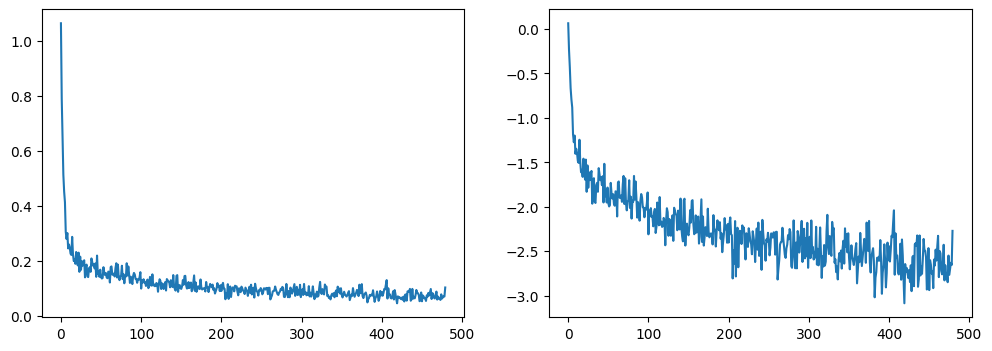

In [30]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))
axs[0].plot(losses)
axs[1].plot(np.log(losses))
plt.show()

In [31]:
# Uncomment to instead load the model I trained earlier:
# model = butterfly_pipeline.unet

In [32]:
#generating images
from diffusers import DDPMPipeline

image_pipe = DDPMPipeline(unet=model, scheduler=noise_scheduler)

  0%|          | 0/1000 [00:00<?, ?it/s]

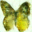

In [33]:
pipeline_output = image_pipe()
pipeline_output.images[0]

In [34]:
image_pipe.save_pretrained("my_pipeline")

In [35]:
%ls my_pipeline

 Volume in drive C is OS
 Volume Serial Number is DCDC-690D

 Directory of c:\Users\hesal5042\OneDrive - University of Bergen\Research\NORCE\Diffusion Model\Code\my_pipeline

13.10.2024  18:33    <DIR>          .
15.10.2024  11:34    <DIR>          ..
15.10.2024  11:36               198 model_index.json
13.10.2024  18:33    <DIR>          scheduler
13.10.2024  18:33    <DIR>          unet
               1 File(s)            198 bytes
               4 Dir(s)  886�340�878�336 bytes free


In [36]:
%ls my_pipeline\unet

 Volume in drive C is OS
 Volume Serial Number is DCDC-690D

 Directory of c:\Users\hesal5042\OneDrive - University of Bergen\Research\NORCE\Diffusion Model\Code\my_pipeline\unet

13.10.2024  18:33    <DIR>          .
13.10.2024  18:33    <DIR>          ..
15.10.2024  11:36             1�011 config.json
15.10.2024  11:36        74�185�252 diffusion_pytorch_model.safetensors
               2 File(s)     74�186�263 bytes
               2 Dir(s)  886�340�812�800 bytes free


C:\Users\hesal5042\AppData\Local\Temp\ipykernel_20168\1866057003.py:6: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  grid_im = Image.fromarray(np.array(grid_im).astype(np.uint8))


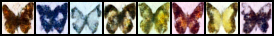

In [37]:
# Random starting point (8 random images):
sample = torch.randn(8, 3, 32, 32).to(device)

for i, t in enumerate(noise_scheduler.timesteps):

    # Get model pred
    with torch.no_grad():
        residual = model(sample, t).sample

    # Update sample with step
    sample = noise_scheduler.step(residual, t, sample).prev_sample

show_images(sample)

In [38]:
#Push your model to the Hub
from huggingface_hub import get_full_repo_name

model_name = "sd-class-butterflies-32"
hub_model_id = get_full_repo_name(model_name)
hub_model_id

'Heebah/sd-class-butterflies-32'

In [39]:
from huggingface_hub import HfApi, create_repo

create_repo(hub_model_id)
api = HfApi()
api.upload_folder(folder_path="my_pipeline/scheduler", path_in_repo="", repo_id=hub_model_id)
api.upload_folder(folder_path="my_pipeline/unet", path_in_repo="", repo_id=hub_model_id)
api.upload_file(
    path_or_fileobj="my_pipeline/model_index.json",
    path_in_repo="model_index.json",
    repo_id=hub_model_id,
)

HfHubHTTPError: 409 Client Error: Conflict for url: https://huggingface.co/api/repos/create (Request ID: Root=1-670e37d6-5886e3982b6099c412215aa7;a2a3a8de-3034-4547-93ea-b73de35d76b1)

You already created this model repo

In [40]:
from huggingface_hub import ModelCard

content = f"""
---
license: mit
tags:
- pytorch
- diffusers
- unconditional-image-generation
- diffusion-models-class
---

# Model Card for Unit 1 of the [Diffusion Models Class 🧨](https://github.com/huggingface/diffusion-models-class)

This model is a diffusion model for unconditional image generation of cute 🦋.

## Usage

```python
from diffusers import DDPMPipeline

pipeline = DDPMPipeline.from_pretrained('{hub_model_id}')
image = pipeline().images[0]
image"""

In [93]:
card = ModelCard(content) 
card.push_to_hub(hub_model_id)

CommitInfo(commit_url='https://huggingface.co/Heebah/sd-class-butterflies-32/commit/f853ba4a832e47f8f8ba19ef3b647670959a1519', commit_message='Upload README.md with huggingface_hub', commit_description='', oid='f853ba4a832e47f8f8ba19ef3b647670959a1519', pr_url=None, repo_url=RepoUrl('https://huggingface.co/Heebah/sd-class-butterflies-32', endpoint='https://huggingface.co', repo_type='model', repo_id='Heebah/sd-class-butterflies-32'), pr_revision=None, pr_num=None)

In [44]:
image_pipe = DDPMPipeline.from_pretrained(hub_model_id)
pipeline_output = image_pipe()

Loading pipeline components...:   0%|          | 0/2 [00:00<?, ?it/s]

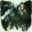

In [97]:
pipeline_output.images[0]